In [1]:
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt
import pandas as pd
import torch
import itertools
from itertools import combinations_with_replacement
from itertools import combinations
from itertools import permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

log_plot = True

import bo_methods_lib

#Note: Need to normalize all values

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def grid_sampling(num_points, bounds):
        """
        Generates Grid sampled data
        
        Parameters
        ----------
        num_points: int, number of points in LHS, should be greater than # of dimensions
        bounds: ndarray, array containing upper and lower bounds of elements in LHS sample. Defaults of 0 and 1
        
        Returns:
        ----------
        grid_data: ndarray, (num_points)**bounds.shape[1] grid sample of data
        
        """
        #Generate mesh_grid data for theta_set in 2D
        #Define linspace for theta
        params = np.linspace(0,1, num_points)
        #Define dimensions of parameter
        dimensions = bounds.shape[1]
        #Generate the equivalent of all meshgrid points
        df = pd.DataFrame(list(itertools.product(params, repeat=dimensions)))
        df2 = df.drop_duplicates()
        scaled_data = df2.to_numpy()
        #Normalize to bounds 
        lower_bound = bounds[0]
        upper_bound = bounds[1]
        grid_data = scaled_data*(upper_bound - lower_bound) + lower_bound 
        return grid_data
    
##New Cell

## define function that includes nonlinear model
def model(theta_guess, theta_ref, x, min_muller, indeces_to_consider):
    '''
        """
    Creates Muller potential values given a guess for "a"
    Parameters
    ----------
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, Independent variable data (exp or pred)
    Returns
    -------
        y_model: ndarray, The simulated Muller potential given the guess
    '''
    #Define an array to store y values in
    y_data = []
    #Loop over all theta values
    for i in range(len(x)):
        #Create model coefficient from true space substituting in the values of param_space at the correct indeces
        model_coefficients = theta_ref.copy()
        #Replace coefficients a specified indeces with their theta_val counterparts
        model_coefficients[indeces_to_consider] = theta_guess              
        #Create y data coefficients
        y_data.append(calc_muller(model_coefficients, x[i], min_muller))

    #Convert list to array and flatten array
    y_model = np.array(y_data).flatten()
    
    return y_model

# print(model(a_guess, theta_ref, Xexp, min_muller, indeces_to_consider))

##New Cell

# Create a function to optimize, in this case, least squares fitting
def regression_func(theta_guess, theta_ref, x, min_muller, indeces_to_consider, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    
    error = y - model(theta_guess, theta_ref, x, min_muller, indeces_to_consider); #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

# print(regression_func(a_guess, Constants, Xexp, Yexp))
# def sse_func(a_model, x, y, P_inds, P1_vals, P2_vals, skip_params):
# heat_map_data_dict[hm_data_keys[0]]
def sse_func(theta_guesses, theta_ref, min_muller, indeces_to_consider, Xexp, Yexp):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all a_1 values
        yy: An D X N array of all a_2 values
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    #Initialize sse grid
    sse = np.zeros(len(theta_guesses))
    
    #For each guess
    for i in range(len(theta_guesses)):
        #Evaluate the model
        y_sim = model(theta_guesses[i], theta_ref, Xexp, min_muller, indeces_to_consider)
        #Calculate SSE
        sse[i] = np.sum((y_sim - Yexp)**2)
     
    sse = sse.reshape(int(np.sqrt(len(theta_guesses))), -1).T
    
    return sse

# print(sse_func(heat_map_data_dict[hm_data_keys[0]], theta_ref, min_muller, indeces_to_consider, Xexp, Yexp))

In [3]:
%%time

param_name_str = "y0"
indeces_to_consider = set_idcs_to_consider(2, param_name_str)

bounds_x = np.array([[-1.5, -0.5], 
                     [1, 2]])
bounds_theta_l = [-300,-200,-250, 5,-2,-2,-10, -2, -2,-2,5,-2,-20,-20, -10,-1 ,-2,-2,-2, -2,-2,-2,0,-2]
bounds_theta_u = [-100,  0, -150, 20,2, 2, 0,  2,  2,  2, 15,2, 0,0   , 0,  2, 2,  2, 2, 2 ,2 , 2, 2,2]

theta_ref = np.array([-200,-100,-170,15,  -1,-1,-6.5,0.7,  0,0,11,0.6,  -10,-10,-6.5,0.7,  1,0,-0.5,-1,   0,0.5,1.5,1])
theta_names = ['A_1', 'A_2', 'A_3', 'A_4', 'a_1', 'a_2', 'a_3', 'a_4', 'b_1', 'b_2', 'b_3', 'b_4', 'c_1', 
                       'c_2', 'c_3', 'c_4', 'x0_1', 'x0_2', 'x0_3', 'x0_4', 'y0_1', 'y0_2', 'y0_3', 'y0_4']
theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

# This generates experimental data points
num_points = 5
Xexp = grid_sampling(num_points, bounds_x)
min_mul_val = solve_pyomo_Muller_min(param_name_str)
min_muller = {"min muller": min_mul_val}
# Evaluate model and add noise based on assumed theta values
Yexp_org = [ calc_muller(theta_ref, Xexp[i], min_muller)  for i in range(len(Xexp)) ]
noise = np.random.normal(size=len(Yexp_org), loc = 0, scale = 0.01)
Yexp = Yexp_org + noise

CPU times: user 9.78 ms, sys: 25.9 ms, total: 35.7 ms
Wall time: 72.5 ms


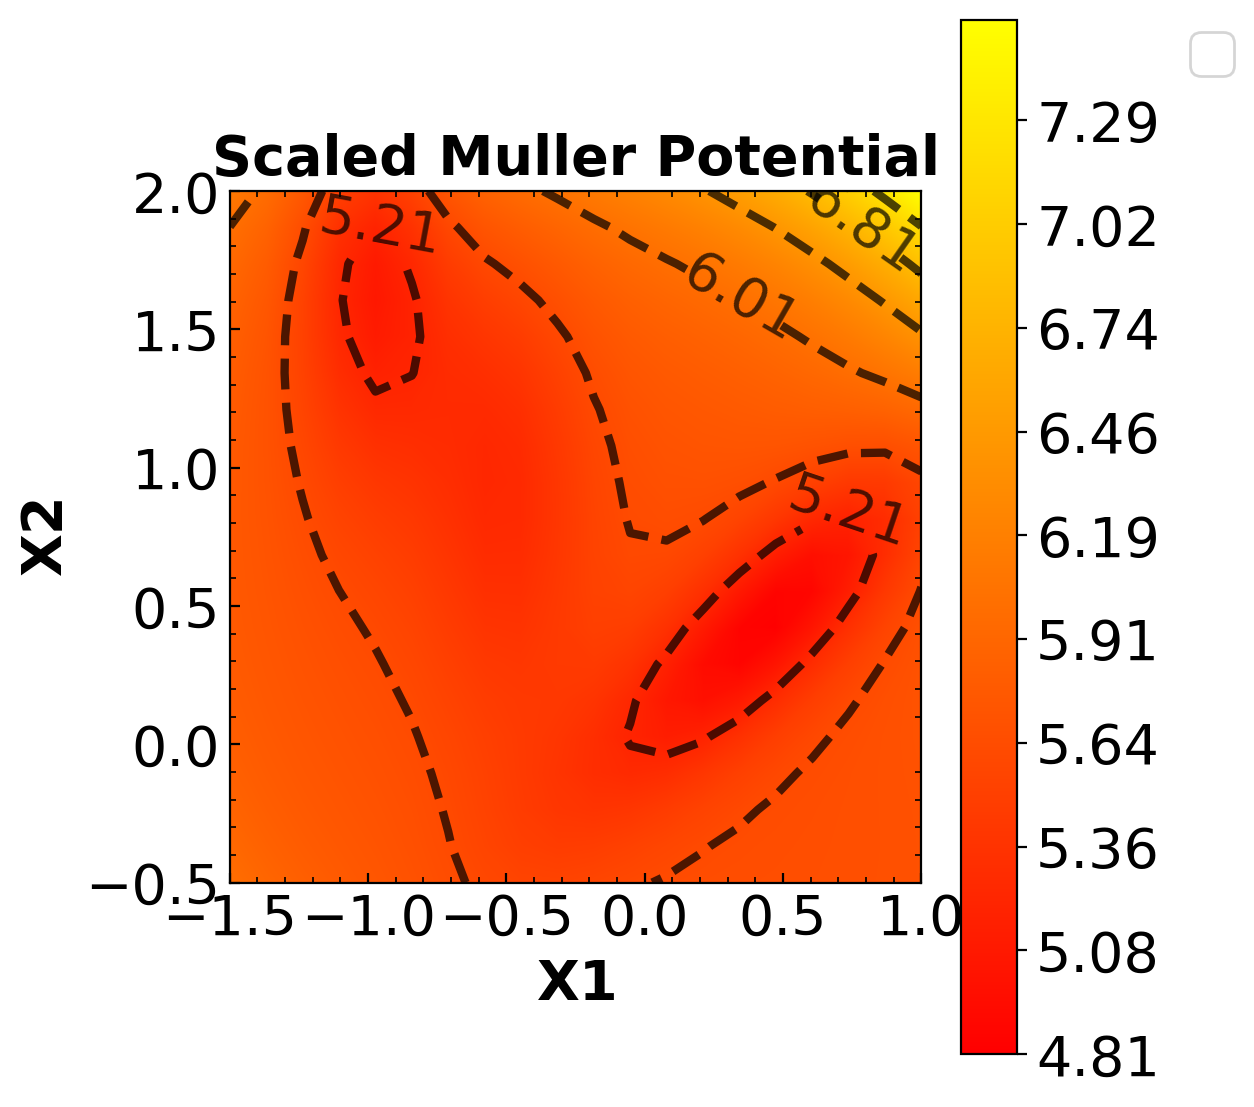

In [4]:
##New Cell

# Evaluate model based on the assumed experimental values
#Create Meshgrid for X1 and X2 and evaluate Y
len_mesh_data = 20
x1 = np.linspace(np.min(Xexp[:,0]),np.max(Xexp[:,0]),len_mesh_data)
x2 = np.linspace(np.min(Xexp[:,1]),np.max(Xexp[:,1]),len_mesh_data)
X1, X2 = np.meshgrid(x1,x2)
X_mesh = np.meshgrid(x1,x2)
X_mesh_reshape = np.array(X_mesh).reshape(2,-1).T
# #Creates an array for Y that will be filled with the for loop

#Calculate y_sim
Y =  [ calc_muller(theta_ref, X_mesh_reshape[i], min_muller) for i in range(len(X_mesh_reshape)) ] 
        
#Reshape to correct dimension (Is there an easier wat to do this?)        
param_names = ["X1", "X2"]
levels = [100]
idcs_to_plot = [0]
zz = np.array(Y).reshape(len_mesh_data,-1).T
z = np.array([zz])
z_titles = ["Scaled Muller Potential"]
xbins = 5
ybins = 5
zbins = 900
title= None

plot_heat_maps(X_mesh, None, None, None, None, param_names, levels, 
               idcs_to_plot, z, z_titles, xbins, ybins, zbins, title)

In [5]:
%%time

#Set seed and repeats
seed = 1
np.random.seed(seed)
repeats = 5

## specify bounds
lower = np.array([bounds_theta_l[i] for i in indeces_to_consider] )
upper = np.array([bounds_theta_u[i] for i in indeces_to_consider] )
bounds = (lower, upper) 

## specify initial guesses
theta_guess = np.random.uniform(low=lower, high=upper, size=(repeats, len(lower)) )
theta_vals = np.zeros((repeats, len(lower)))
l2_norms = np.zeros(repeats)
costs = np.zeros(repeats)
fxn_evals = np.zeros(repeats)

for i in range(repeats):
    Solution = optimize.least_squares(regression_func, theta_guess[i] ,bounds=bounds, method='trf',
                                      args=(theta_ref, Xexp, min_muller, indeces_to_consider, Yexp),verbose=0)

    theta_min_obj = Solution.x
    costs[i] = Solution.cost
    theta_vals[i] = theta_min_obj
    #Note counting Jacobian and function evalauations as function evaluations
    fxn_evals[i] = Solution.nfev + Solution.njev
    
    del_theta = theta_min_obj - theta_true
    theta_L2_norm = np.linalg.norm(del_theta, ord = 2)
    l2_norms[i] = theta_L2_norm
    
nlr_theta = theta_vals[np.argmin(costs)]
nlr_l2_norm = l2_norms[np.argmin(costs)]
nlr_evals = fxn_evals[np.argmin(costs)]
print("Best Theta = ", nlr_theta)
print("Best Theta L2 norm = ", nlr_l2_norm)
print("Evaluations = ", nlr_evals)
print("theta_ref", theta_true)
Y_nlr_exp = model(nlr_theta, theta_ref, Xexp, min_muller, indeces_to_consider)
error = (Yexp - Y_nlr_exp)
print("SSE = ", np.sum(error**2))

Best Theta =  [-0.04964444  0.37457658  0.88041718  1.02321564]
Best Theta L2 norm =  0.6345214270443588
Evaluations =  28.0
theta_ref [0.  0.5 1.5 1. ]
SSE =  0.5116252311302957
CPU times: user 235 ms, sys: 17.5 ms, total: 252 ms
Wall time: 235 ms


In [6]:
# a1, a2, a3, a4 = np.meshgrid(a1_lin, a2_lin, a3_lin, a4_lin)
# a_guesses = np.meshgrid(a1_lin, a2_lin, a3_lin, a4_lin)

# P_inds = np.array([0,3])
# print(sse_func(a_model, Xexp, Yexp, P_inds, a1_lin, a2_lin))

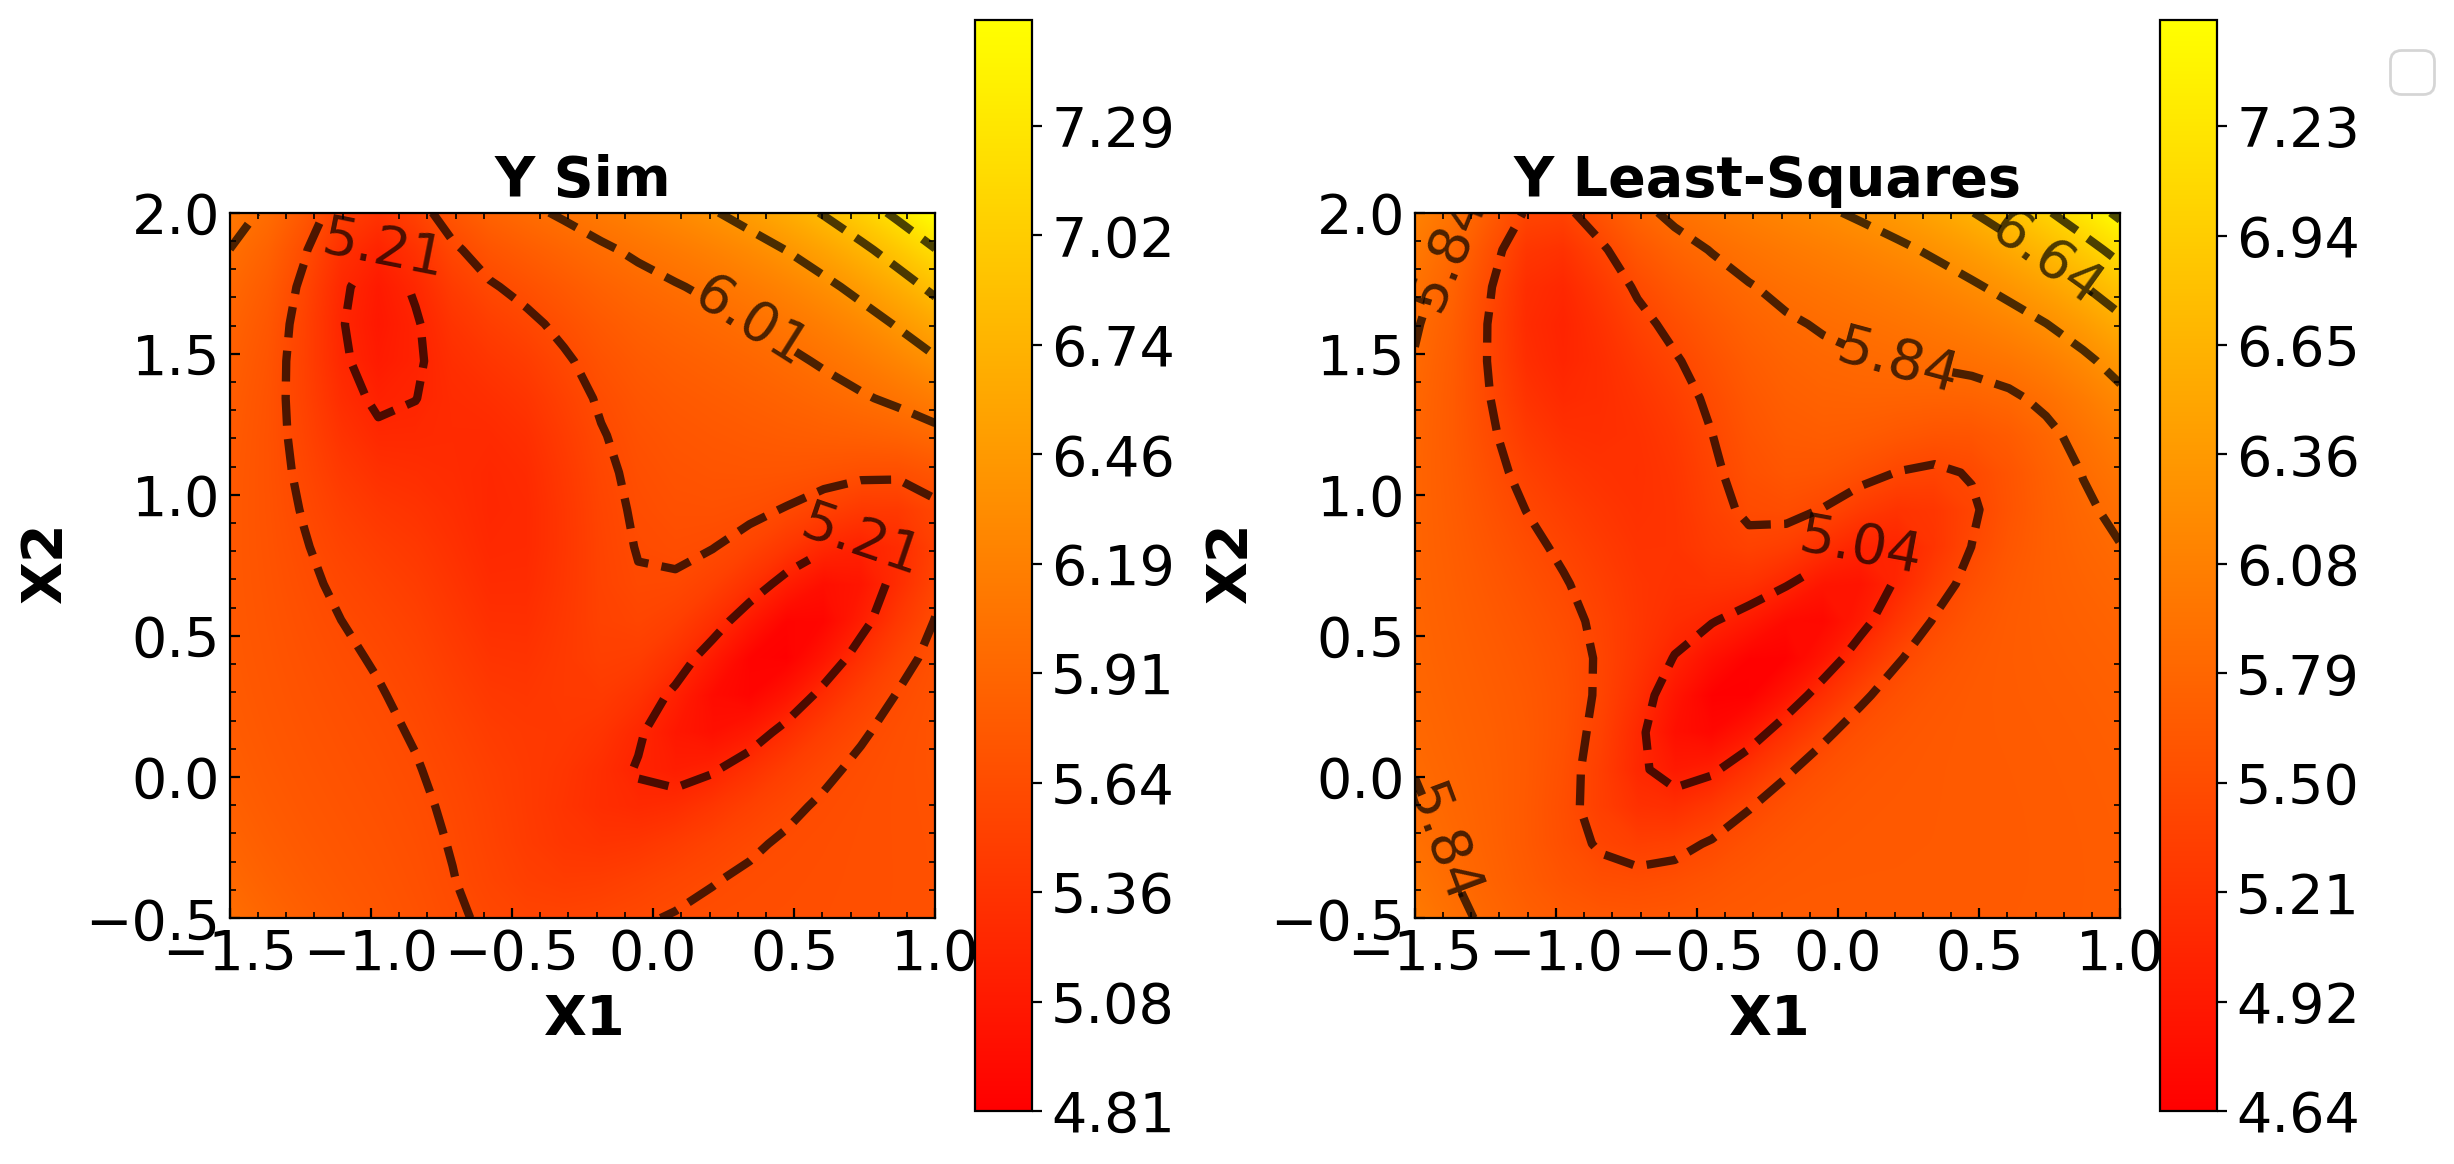

In [7]:
##New Cell
#Create Meshgrid for X1 and X2 and evaluate Y
len_mesh_data = 20
x1 = np.linspace(np.min(Xexp[:,0]),np.max(Xexp[:,0]),len_mesh_data)
x2 = np.linspace(np.min(Xexp[:,1]),np.max(Xexp[:,1]),len_mesh_data)
X1, X2 = np.meshgrid(x1,x2)
X_mesh = np.meshgrid(x1,x2)
X_mesh_reshape = np.array(X_mesh).reshape(2,-1).T
# #Creates an array for Y that will be filled with the for loop

#Calculate y_sim
Y_nlr = model(nlr_theta, theta_ref, X_mesh_reshape, min_muller, indeces_to_consider)
        
#Reshape to correct dimension (Is there an easier wat to do this?)        
param_names = ["X1", "X2"]
levels = [100]
idcs_to_plot = [0]
y_sim = np.array(Y).reshape(len_mesh_data,-1).T
y_nlr = np.array(Y_nlr).reshape(len_mesh_data,-1).T
z = np.array([y_sim, y_nlr])
z_titles = ["Y Sim", "Y Least-Squares"]
xbins = 5
ybins = 5
zbins = 900
title= None

plot_heat_maps(X_mesh, None, None, None, None, param_names, levels, 
               idcs_to_plot, z, z_titles, xbins, ybins, zbins, title)

SSE =  0.5116252311302957


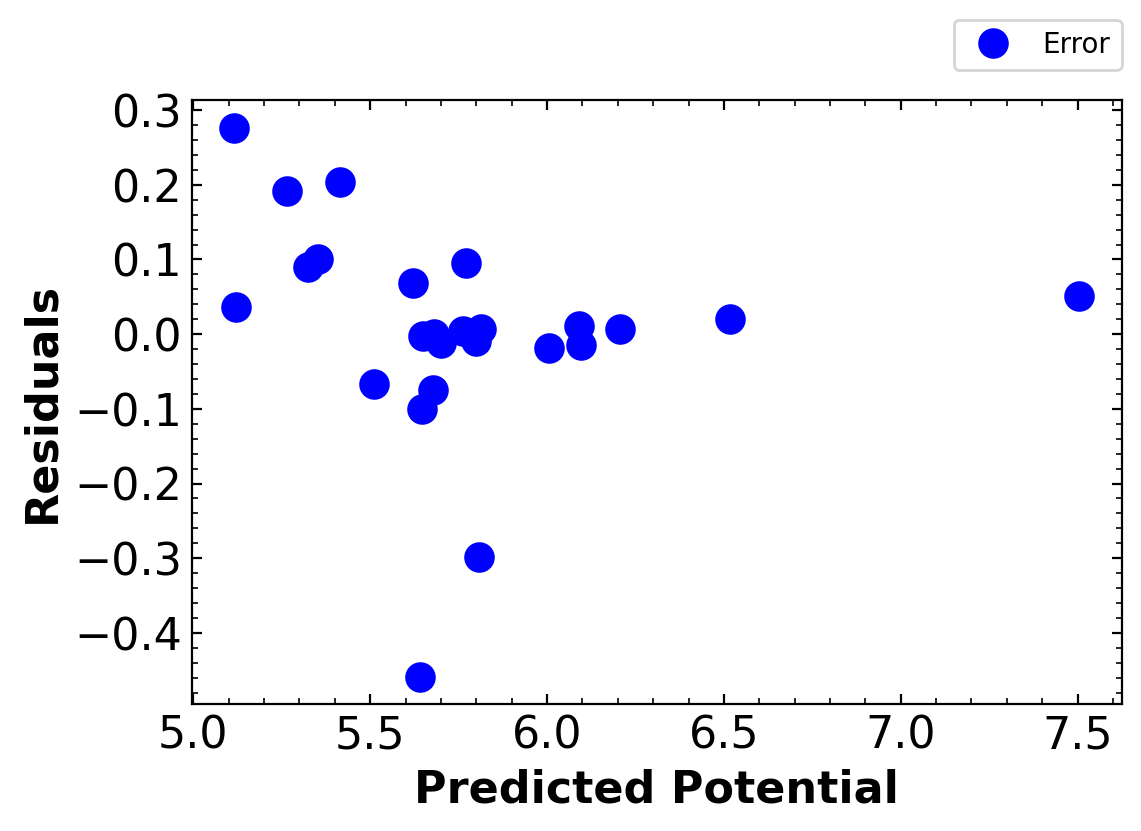

In [8]:
#Plot error
Y_nlr_exp = model(nlr_theta, theta_ref, Xexp, min_muller, indeces_to_consider)
error = (Yexp - Y_nlr_exp)
print("SSE = ", np.sum(error**2))
plt.plot(Y_nlr_exp, error,"b.",markersize=20, label = "Error")

plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0, loc = "lower right")

plt.minorticks_on() # turn on minor ticks
plt.tick_params(direction="in",top=True, right=True) 
plt.tick_params(which="minor",direction="in",top=True, right=True)

plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(False)

# plt.title("Residuals")
plt.xlabel('Predicted Potential', fontsize=16,fontweight='bold')
plt.ylabel('Residuals', fontsize=16,fontweight='bold')
plt.show()

In [9]:
#Create heat map data
#Create list of heat map theta data
heat_map_data_dict = {}

#Create a linspace for the number of dimensions and define number of points
dim_theta = len(theta_true_names)
dim_list = np.linspace(0, dim_theta-1, dim_theta)

#Create a list of all combinations (without repeats e.g no (1,1), (2,2)) of dimensions of theta
mesh_combos = np.array(list(combinations(dim_list, 2)), dtype = int)
n_points = 20

#Meshgrid set always defined by n_points**2
theta_set = np.tile(np.array(theta_true), (n_points**2, 1))

#Set x_vals
norm_x_vals = Xexp

#Loop over all possible theta combinations of 2
for i in range(len(mesh_combos)):
    #Create a copy of the true values to change the mehsgrid valus on
    theta_set_copy = np.copy(theta_set)
    #Set the indeces of theta_set for evaluation as each row of mesh_combos
    idcs = mesh_combos[i]
    #define name of parameter set as tuple ("param_1,param_2")
    data_set_name = (theta_true_names[idcs[0]], theta_true_names[idcs[1]])

    #Create a meshgrid of values of the 2 selected values of theta and reshape to the correct shape
    #Assume that theta1 and theta2 have equal number of points on the meshgrid
    theta1 = np.linspace(lower[idcs[0]], upper[idcs[0]], n_points)
    theta2 = np.linspace(lower[idcs[1]], upper[idcs[1]], n_points)
    theta12_mesh = np.array(np.meshgrid(theta1, theta2))
    theta12_vals = np.array(theta12_mesh).T.reshape(-1,2)

    #Set initial values for evaluation (true values) to meshgrid values
    theta_set_copy[:,idcs] = theta12_vals
    
    #Append data set to dictionary with name
    heat_map_data_dict[data_set_name] = theta_set_copy
    
hm_data_keys = list(heat_map_data_dict.keys())
# print(heat_map_data_dict[hm_data_keys[0]].shape)

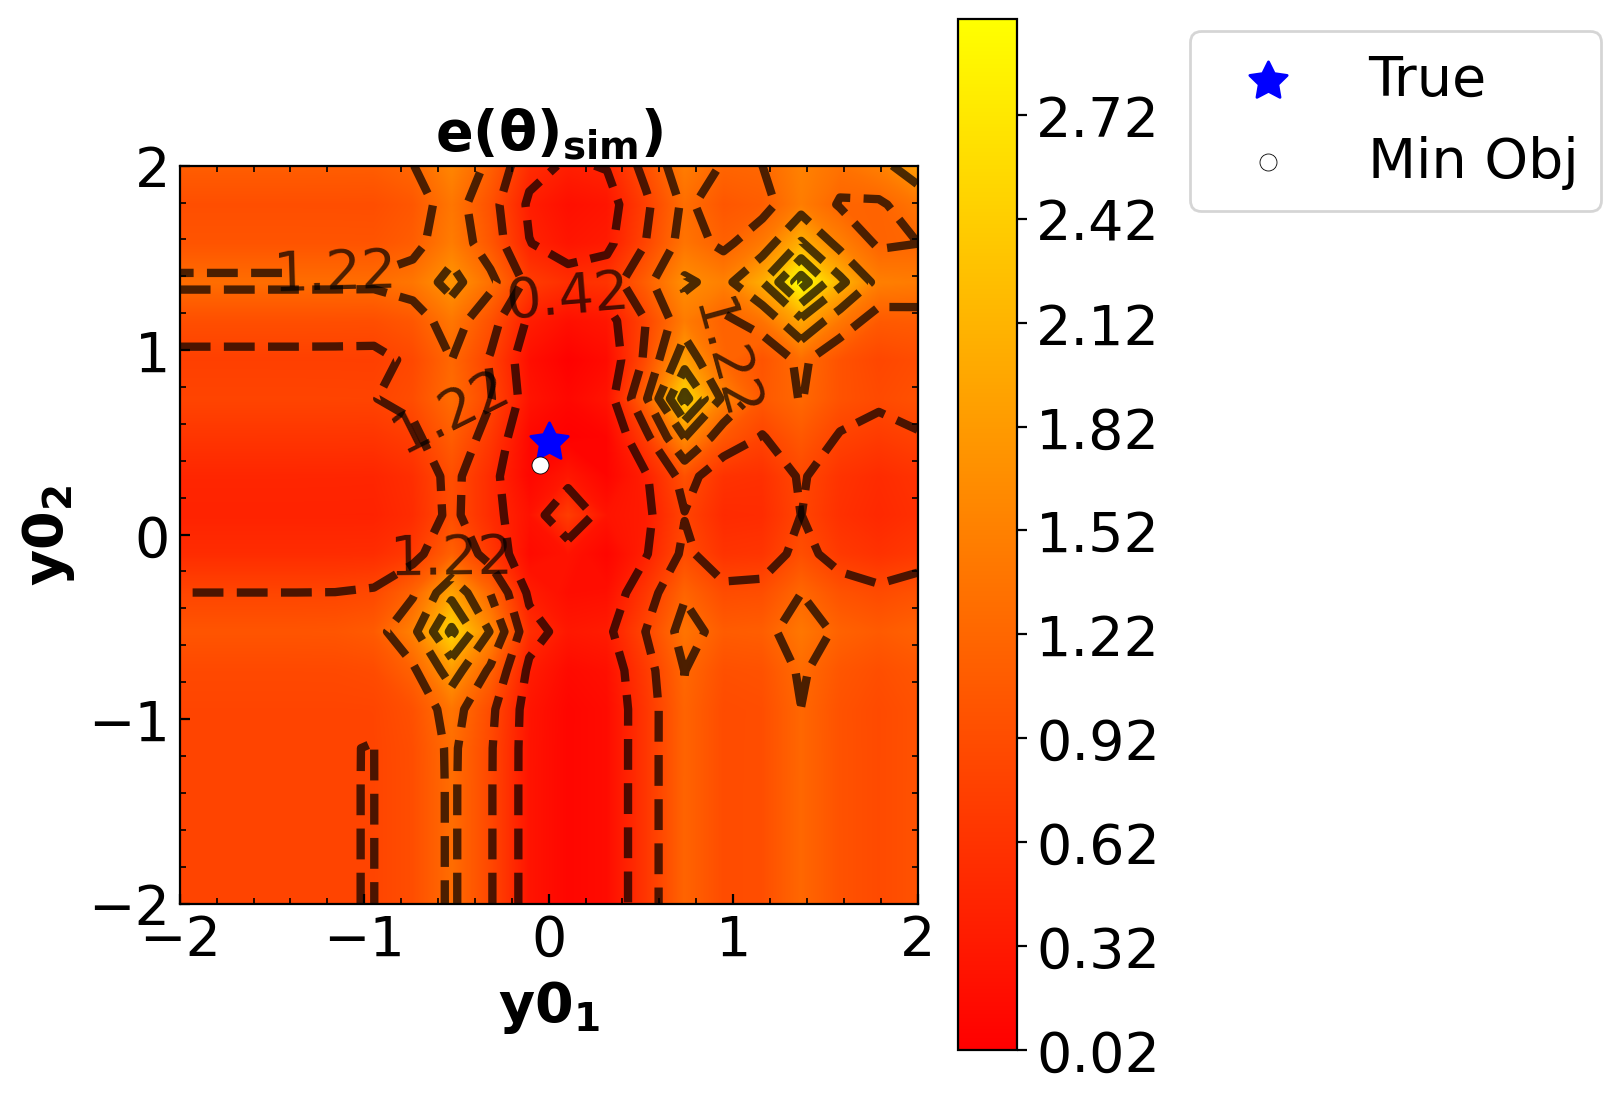

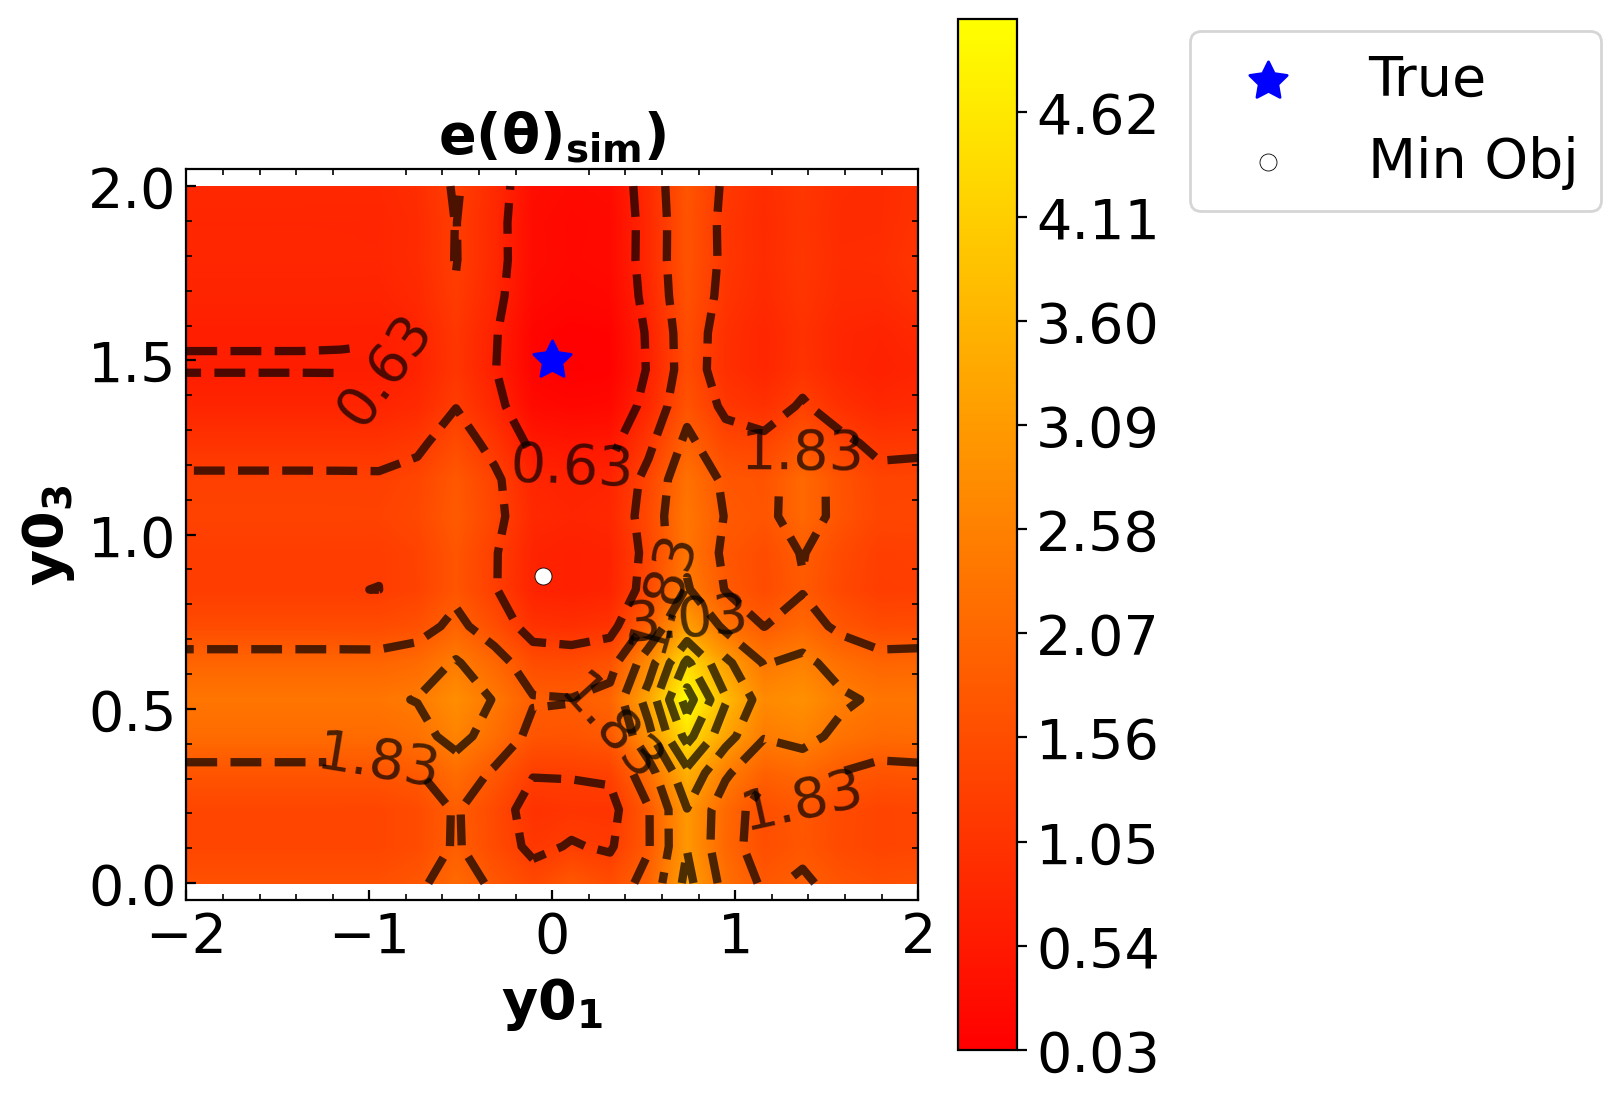

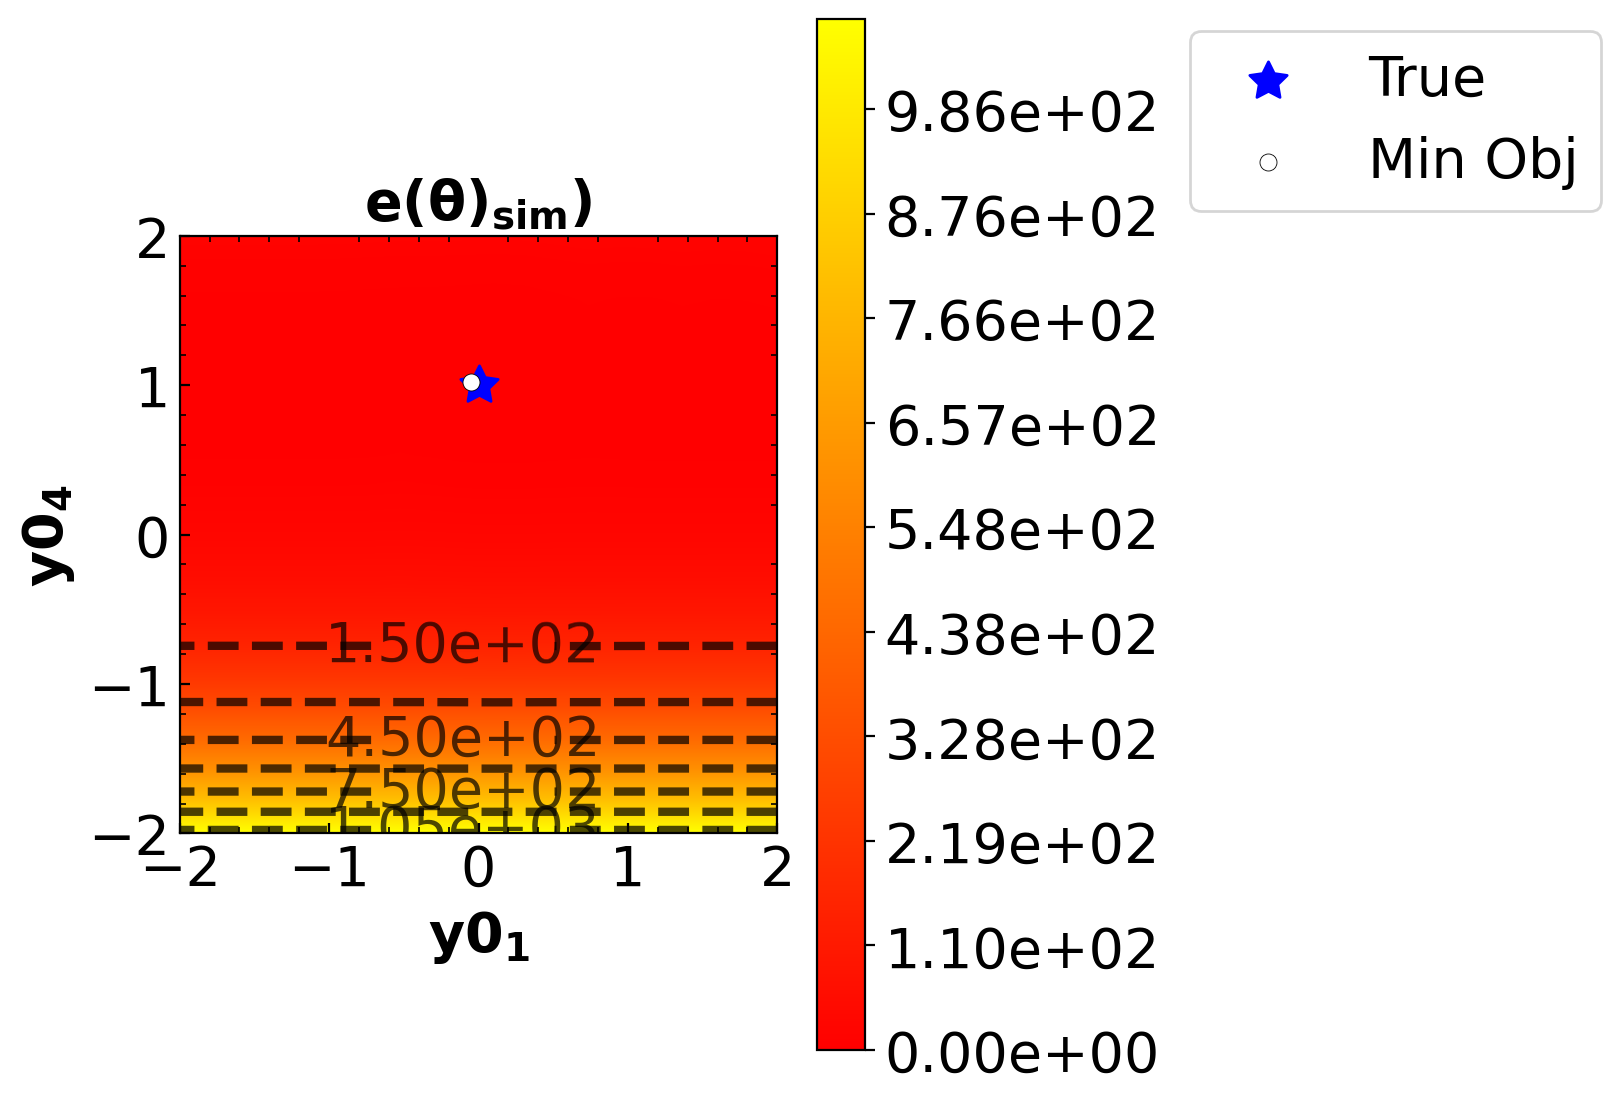

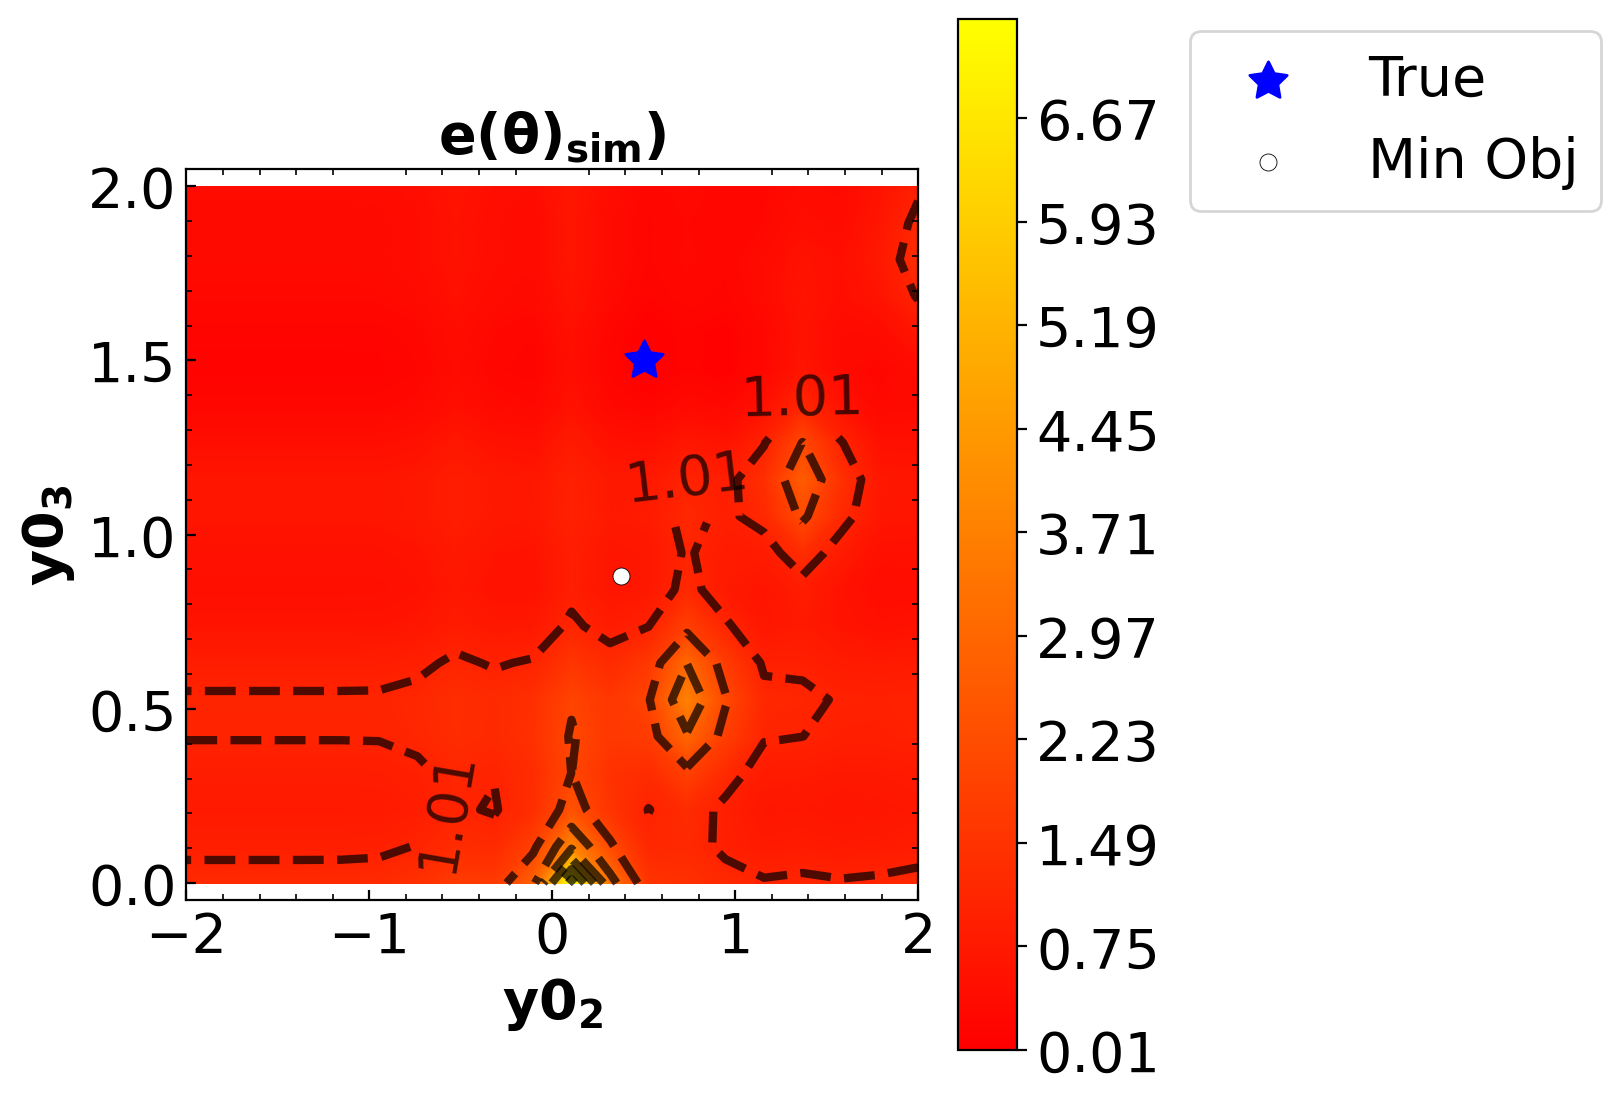

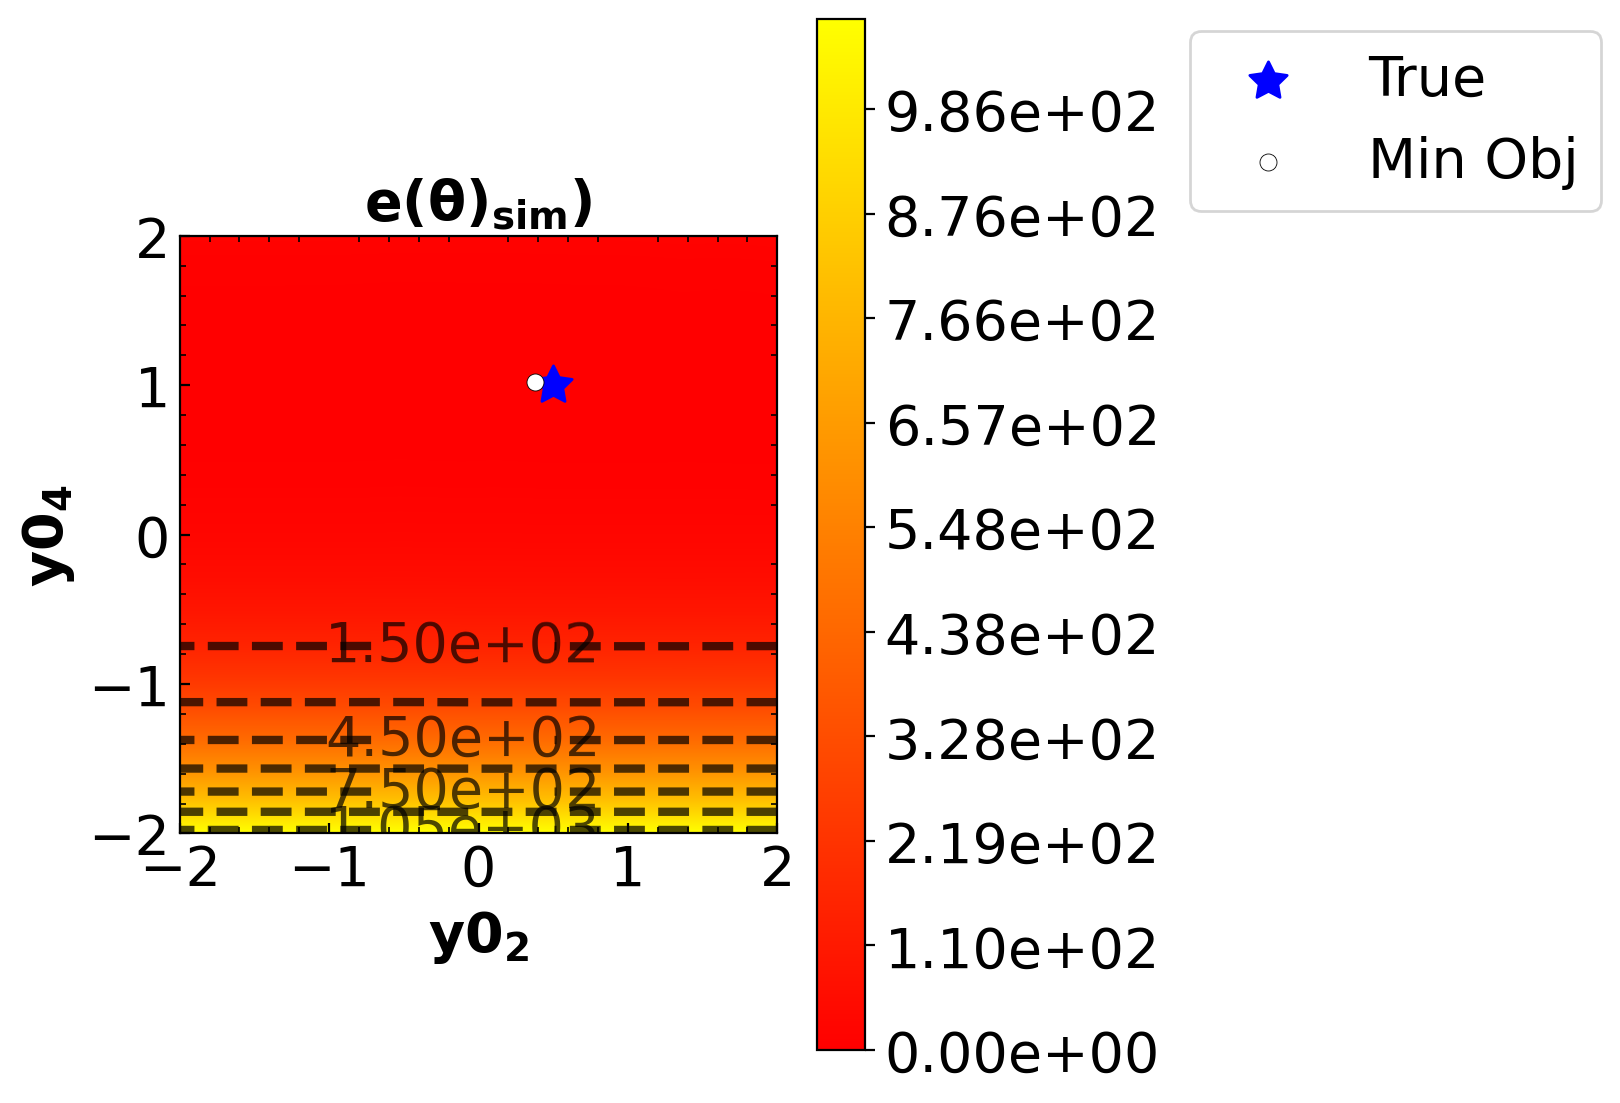

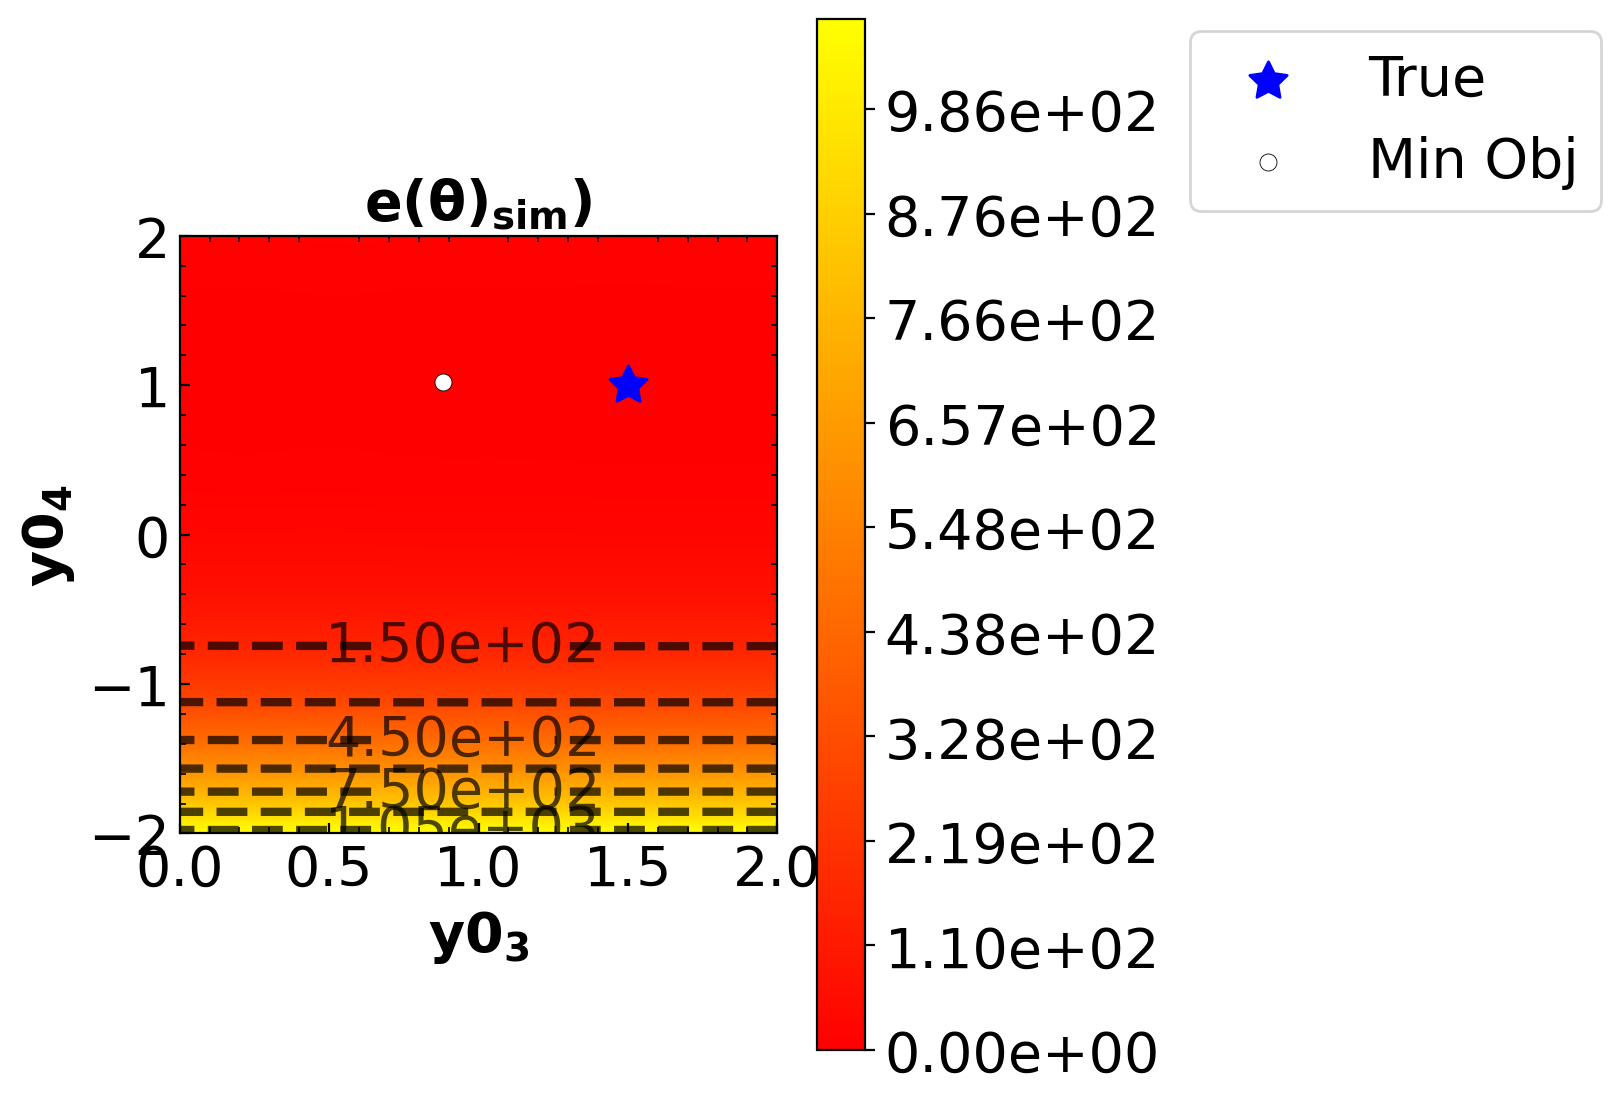

In [10]:
#New Cell
log_data = False
# save_figure = True
save_figure = False
xbins = 5
ybins = 5
zbins = 900
title= None


#Get Number of pairs
combos = list(combinations(dim_list, 2))
pairs = len((list(combinations(dim_list, 2))))

#For each pair
for pair in range(pairs):
    #Make a meshgrid for each parameter
    idcs_to_plot = [int(combos[pair][i]) for i in range(len(combos[pair]))]
    theta_data = heat_map_data_dict[hm_data_keys[pair]].reshape(n_points, n_points, -1).T
    theta_mesh = np.take(theta_data, list(combos[pair]), axis=0)
    
    sse_sim = sse_func(heat_map_data_dict[hm_data_keys[pair]], theta_ref, min_muller, indeces_to_consider, Xexp, Yexp)
    plot_axis_names = theta_true_names[idcs_to_plot]
    
    title = "Heat Map Pair " + "-".join(map(str, plot_axis_names))
    title = None

    z = np.array([sse_sim])
    if log_data == True:
        z_titles = ["ln("+ r"$\mathbf{e(\theta)_{sim}}$" + ")"]
        z = np.log(z)
    else:
        z_titles = [r"$\mathbf{e(\theta)_{sim}}$" + ")"]
    
#     z_save_names = ["sse_sim", "sse_nlr"]
#     path_end = '-'.join(z_save_names) 
    levels = [100]

    plot_heat_maps(theta_mesh, theta_true, nlr_theta, None, None, plot_axis_names, levels, idcs_to_plot, 
                z, z_titles, xbins, ybins, zbins, title)

In [11]:
#Jacobian and Uncertainty Analysis
print("Jacobian =\n")
Jacobian = Solution.jac
print(Jacobian) #Jacobian is fine for simple cases
#Normalize Jacobian
# print("Normalized Jacobian =\n")
# for i in range(len(a_model)):
#     Jacobian[i,:] = Jacobian[i,:]*a_model
# print(Jacobian)

#OR normalize error instead of FIM to solve the problem (2 ways to do this)
# error_normalized = (error - np.average(error)) / np.average(error)
# error_normalized = (error - np.amin(error)) / (np.amax(error)- np.amin(error))
# print("Normalized Error =  \n", error_normalized)

sigre = (error.T @ error)/(len(error) - 2)
# sigre = (error_normalized.T @ error_normalized)/(len(error_normalized) - 2)
# Sigma_theta2 = sigre * np.linalg.inv(Solution.jac.T @ Solution.jac)
Sigma_theta2 = sigre * np.linalg.inv(Jacobian.T @ Jacobian)
print("Covariance matrix:\n",Sigma_theta2)

Jacobian =

[[-7.59959221e-05  0.00000000e+00  1.12603784e-01 -9.01356579e-01]
 [-2.26849318e-03 -6.95016609e-06  1.90056562e-02 -2.08797728e-01]
 [ 8.97943974e-04 -4.36330434e-02  5.72204590e-06 -4.88031393e-02]
 [ 5.96046448e-08  9.81010980e-02  0.00000000e+00  1.22178106e-02]
 [ 0.00000000e+00  9.66470239e-04  0.00000000e+00  9.48354960e-02]
 [-1.58315897e-03  0.00000000e+00 -8.73233914e-01 -4.94276708e-01]
 [-5.48126698e-02 -4.83036543e-05  1.43589669e+00 -1.50725246e-01]
 [ 1.43762827e-02 -2.00141203e-01  4.21224833e-02 -1.75075287e-02]
 [ 9.53674316e-07  4.79867417e-01  5.66244125e-06  3.86534099e-02]
 [ 0.00000000e+00  4.18196458e-03  0.00000000e+00  1.53841495e-01]
 [-9.88215208e-03  0.00000000e+00 -2.40629911e-02 -2.96394969e-01]
 [-4.51856136e-01 -1.14082012e-04 -1.97568089e+00 -1.26002183e-01]
 [ 1.39816284e-01 -5.57674228e-01  1.59741175e+00  7.03266453e-03]
 [ 7.68899918e-06  1.07236093e+00  2.11016536e-02  1.18817991e-01]
 [ 0.00000000e+00  7.55170297e-03  7.74860382e-07 

In [12]:
import scipy.linalg as linalg
val, vec = linalg.eig(Sigma_theta2)
print("Eigenvalues = \n",val)
print("Eigenvectors = \n",vec)

Eigenvalues = 
 [0.0089705 +0.j 0.00519706+0.j 0.00223449+0.j 0.00251549+0.j]
Eigenvectors = 
 [[-0.10960028 -0.97532741 -0.18909462 -0.03110376]
 [-0.98673172  0.10086762  0.03137118  0.12329676]
 [-0.06832476  0.18825989 -0.85179502 -0.48408179]
 [ 0.09838712  0.05586033 -0.4875493   0.86573396]]


In [13]:
FIM = (1/sigre) * Jacobian.T @ Jacobian
print("FIM = \n", FIM)

FIM = 
 [[200.76481233 -11.05335165  43.57333587  18.86899815]
 [-11.05335165 116.97948214 -24.5166992   25.85089866]
 [ 43.57333587 -24.5166992  425.20415888  20.52717474]
 [ 18.86899815  25.85089866  20.52717474 406.0116466 ]]


In [14]:
print(np.linalg.det(FIM))
print(np.linalg.det(Sigma_theta2))
print(sigre)

3816152570.7933545
2.620440303287209e-10
0.022244575266534585


In [15]:
Test = Jacobian.T @ Jacobian
print(np.linalg.det(Test))
print(Test)
val, vec = linalg.eig(Test)
print(val)

934.3771319209144
[[ 4.46592798 -0.24587711  0.96927035  0.41973285]
 [-0.24587711  2.6021589  -0.54536356  0.57504226]
 [ 0.96927035 -0.54536356  9.45848592  0.45661828]
 [ 0.41973285  0.57504226  0.45661828  9.03155663]]
[2.47974792+0.j 4.28022613+0.j 9.95510355+0.j 8.84305182+0.j]
